In [1]:
from datasets import Dataset
import json
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import pandas as pd,os
import torch
from statistics import mode
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pickle

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["text"], truncation=True)
def get_data(train_path, test_path, random_seed):
    """
    function to read dataframe with columns
    """

    train_df = pd.read_json(train_path, lines=True)
    test_df = pd.read_json(test_path, lines=True)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df, test_df

def getMetrics(predicted_labels, true_labels):
    # Ensure the labels are numpy arrays
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro', zero_division=0)

    # Create a dictionary of metrics
    metrics = {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
    }

    return metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Load metrics
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    accuracy_metric = evaluate.load("accuracy")

    # Compute metrics with macro averaging and handle zero division
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    # Compile results
    results = {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
    }

    return results

def fine_tune(train_df, valid_df, checkpoints_path, id2label, label2id, model):

    # pandas dataframe to huggingface Dataset
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)
    
    # get tokenizer and model from huggingface
    tokenizer = AutoTokenizer.from_pretrained(model)     # put your model here
    model = AutoModelForSequenceClassification.from_pretrained(
       model, num_labels=len(label2id), id2label=id2label, label2id=label2id    # put your model here
    )
    
    # tokenize data for train/valid
    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    # create Trainer 
    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # save best model
    best_model_path = checkpoints_path+'/best/'
    
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)
    

    trainer.save_model(best_model_path)

def test(test_df, model_path, id2label, label2id):
    
    # load tokenizer from saved model 
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # load best model
    model = AutoModelForSequenceClassification.from_pretrained(
       model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )
            
    test_dataset = Dataset.from_pandas(test_df)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    probs = softmax(predictions.predictions, axis=-1)
    
    results = getMetrics(preds,test_dataset['label'])
    
    # return dictionary of classification report
    return results, preds

60000 - 0.624
70000 - 0.6203333333333333


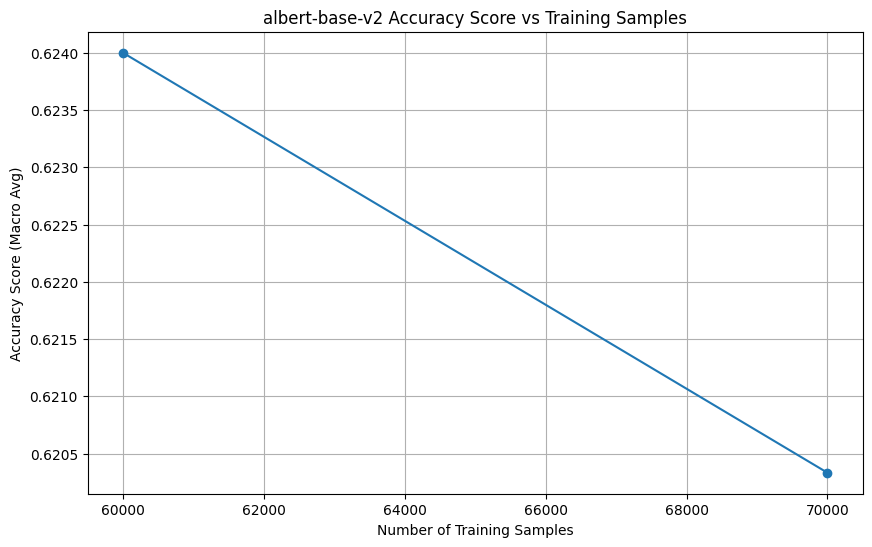

In [3]:
random_seed = 10

model = 'bert-base-uncased'
model = 'roberta-base'
model = 'distilbert-base-uncased'
model = 'google/electra-base-discriminator'
model = 'albert-base-v2'


samples=[500,1000,2000,5000,10000,15000,20000,30000,40000,50000]
samples=[60000,70000]
acc_scores = []

for SAMPLES_TO_TRAIN in samples:

    df= pd.read_json('datasets/subtaskB_train.jsonl', lines=True)

    # df = df.rename(columns={'source': 'language'})
    # non_language_sources = ['wikihow', 'wikipedia', 'reddit', 'arxiv', 'peerread']
    # df['language'] = df['language'].replace(non_language_sources, 'english')
    # rus = RandomUnderSampler(random_state=42)
    # X_resampled, y_resampled = rus.fit_resample(df.drop('language', axis=1), df['language'])
    # df = pd.concat([X_resampled, y_resampled], axis=1)

    df=df.sample(SAMPLES_TO_TRAIN)

    df.to_json('reducedTrainDataFrame.jsonl', orient='records', lines=True)

    train_path =  'reducedTrainDataFrame.jsonl'
    test_path =  'datasets/subtaskB_dev.jsonl'

    subtask =  'B'
    prediction_path = 'reducedPredictedDataFrame.jsonl'

    if not os.path.exists(train_path):
        logging.error("File doesnt exists: {}".format(train_path))
        raise ValueError("File doesnt exists: {}".format(train_path))

    if not os.path.exists(test_path):
        logging.error("File doesnt exists: {}".format(train_path))
        raise ValueError("File doesnt exists: {}".format(train_path))

    if subtask == 'A':
        id2label = {0: "human", 1: "machine"}
        label2id = {"human": 0, "machine": 1}
    elif subtask == 'B':
        id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
        label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}
    else:
        logging.error("Wrong subtask: {}. It should be A or B".format(train_path))
        raise ValueError("Wrong subtask: {}. It should be A or B".format(train_path))

    set_seed(random_seed)

    train_df, valid_df, test_df = get_data(train_path, test_path, random_seed)

    fine_tune(train_df, valid_df, f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}", id2label, label2id, model)

    results, predictions = test(test_df, f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}/best/", id2label, label2id)
    
    acc_score=results['accuracy']

    with open(f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}/best/acc_score.json", 'w') as file:
        json.dump({'Accuracy': acc_score}, file)
    
    acc_scores.append(acc_score)
        
    print(f'\n\n****** {SAMPLES_TO_TRAIN} - {acc_score} ******\n\n')

from IPython.display import clear_output
clear_output(wait=True)

for SAMPLES_TO_TRAIN,acc_score in zip(samples,acc_scores):
    print(f'{SAMPLES_TO_TRAIN} - {acc_score}')

import matplotlib.pyplot as plt
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(samples, acc_scores, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy Score (Macro Avg)')
plt.title(f'{model} Accuracy Score vs Training Samples')
plt.grid(True)
plt.savefig(f"testing_models/{model.split('/')[-1]}_optimized_acc_scores.png")
plt.show()

500 - 0.363
1000 - 0.5356666666666666
2000 - 0.595
5000 - 0.5996666666666667
10000 - 0.6653333333333333
15000 - 0.674
20000 - 0.6336666666666667
30000 - 0.6566666666666666
40000 - 0.6253333333333333
50000 - 0.6376666666666667
60000 - 0.624
70000 - 0.6203333333333333


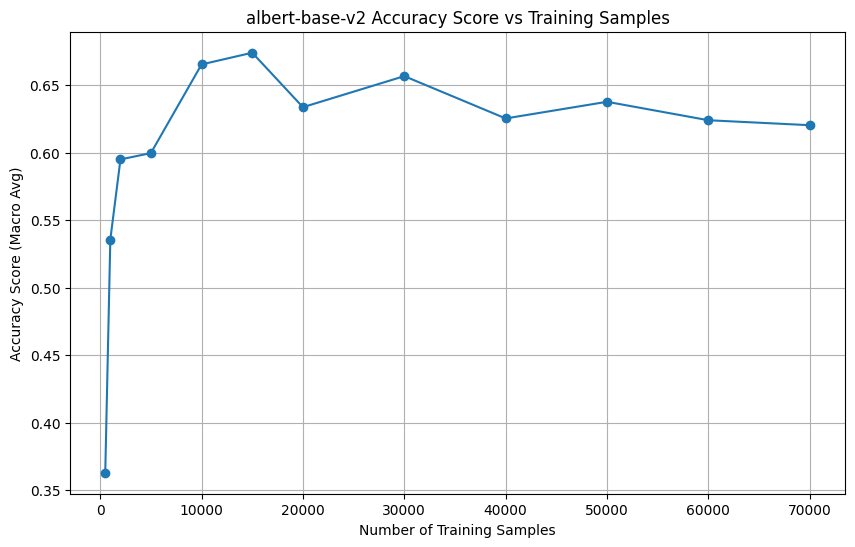

In [4]:
samples=[]
acc_scores=[]

a='''
500 - 0.363
1000 - 0.5356666666666666
2000 - 0.595
5000 - 0.5996666666666667
10000 - 0.6653333333333333
15000 - 0.674
20000 - 0.6336666666666667
30000 - 0.6566666666666666
40000 - 0.6253333333333333
50000 - 0.6376666666666667
60000 - 0.624
70000 - 0.6203333333333333
'''
lines = a.split('\n')

a_values = []
b_values = []
for line in lines:
    try:
        value_a, value_b = line.split(' - ')
        a_values.append(int(value_a))  
        b_values.append(float(value_b))
    except:
        pass

samples=a_values
acc_scores=b_values

for SAMPLES_TO_TRAIN,acc_score in zip(samples,acc_scores):
    print(f'{SAMPLES_TO_TRAIN} - {acc_score}')

import matplotlib.pyplot as plt
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(samples, acc_scores, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy Score (Macro Avg)')
plt.title(f'{model} Accuracy Score vs Training Samples')
plt.grid(True)
plt.savefig(f"testing_models/{model.split('/')[-1]}_optimized_acc_scores.png")
plt.show()